# The Battle of the Neighborhoods: London 

### 1. Introduction

As one of the major cultural and financial capitals of Europe, London is a dynamic and transient city that attracts expatriates across all nationalities. A major task of relocation that these individuals must tackle includes deciding where one should buy or rent a property. However, London’s real estate market can be daunting due to its sheer size, diversity, and competitiveness. This report aims to predict the best neighborhood based on certain factors.

The target audience for this report include: those who are interested in buying or renting a property in London, such as those who are relocating to London, those who would like to invest in property for their financial portfolio, or those who are looking to settle down. As a young professional trying to move to London, I would personally benefit from this report as it would help me determine best areas based on safety, affordability, and vibe. 

Determining the best neighborhood varies for everyone.  For the purposes of this report, we will consider the following factors: affordability, accessibility, and nearby facilities, such as parks, pharmacies, pubs, etc. The data will mainly be taken with Foursquare location data. 

### 2. Data

The following data sources will be utilized in this project: 

1. London borough data: https://en.wikipedia.org/wiki/List_of_London_boroughs.
2. Crime records in London: https://www.kaggle.com/jboysen/london-crime.
3. Housing affordability: https://webarchive.nationalarchives.gov.uk/20171102125110/https://visual.ons.gov.uk/wp-content/uploads/2017/10/map.csv
4. Happiness index: https://www.itv.com/news/london/2016-08-16/londons-happiest-boroughs-revealed-as-richmond-hits-the-top-spot/.

First, we need to import the necessary libraries. 

In [4]:
!pip install folium

     |████████████████████████████████| 92kB 18.1MB/s eta 0:00:01


In [7]:
import requests 
import bs4 
import numpy as np 
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import os 
import json 

from geopy.geocoders import Nominatim 

from pandas.io.json import json_normalize

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

import folium 

Now we need to read the JSON file from the wikipedia page and then get the table data for the borough names. 

In [8]:
web_link = 'https://en.wikipedia.org/wiki/List_of_London_boroughs'
response = requests.get(web_link)

try:
    response.raise_for_status()
    soup_obj = bs4.BeautifulSoup(response.text, 'html.parser')
    
except Exception as exc:
    print('Error while downloading the webpage.. %s' % exc)

In [9]:
content = soup_obj.find('table', attrs={'class':"wikitable sortable"})
content

<table class="wikitable sortable" style="font-size:100%" width="100%">
<tbody><tr>
<th>Borough
</th>
<th>Inner
</th>
<th>Status
</th>
<th>Local authority
</th>
<th>Political control
</th>
<th>Headquarters
</th>
<th>Area (sq mi)
</th>
<th>Population (2013 est)<sup class="reference" id="cite_ref-1"><a href="#cite_note-1">[1]</a></sup>
</th>
<th>Co-ordinates
</th>
<th><span style="background:#67BCD3"> Nr. in map </span>
</th></tr>
<tr>
<td><a href="/wiki/London_Borough_of_Barking_and_Dagenham" title="London Borough of Barking and Dagenham">Barking and Dagenham</a> <sup class="reference" id="cite_ref-2"><a href="#cite_note-2">[note 1]</a></sup>
</td>
<td>
</td>
<td>
</td>
<td><a href="/wiki/Barking_and_Dagenham_London_Borough_Council" title="Barking and Dagenham London Borough Council">Barking and Dagenham London Borough Council</a>
</td>
<td><a href="/wiki/Labour_Party_(UK)" title="Labour Party (UK)">Labour</a>
</td>
<td><a class="new" href="/w/index.php?title=Barking_Town_Hall&amp;action

Create the table with the borough names. 

In [10]:
import re
column_name = ['London_Borough'] 
data_frame = pd.DataFrame(columns=column_name)

for row in content.findAll('tr'):
    line_item = row.findAll('td')
    if line_item:
        name1 = line_item[0].text.strip()
        re_obj = re.compile('\[')
        split_obj = re_obj.split(name1)
        borough_name = split_obj[0].strip()
        data_frame = data_frame.append({'London_Borough': borough_name},
                                        ignore_index=True)
        
data_frame

,London_Borough
0,Barking and Dagenham
1,Barnet
2,Bexley
3,Brent
4,Bromley
5,Camden
6,Croydon
7,Ealing
8,Enfield
9,Greenwich


Next, let's retrieve the crime record dataset. 

London Crime Data: https://www.kaggle.com/jboysen/london-crime.

In [ ]:
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_ab601c5a8c114b46b548cdbdbf1bf655 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='xFEQERp0ng7h3NeTfTTGvoWfoIhlV1pfLP2EFFzBjv2n',
    ibm_auth_endpoint="https://iam.ng.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_ab601c5a8c114b46b548cdbdbf1bf655.get_object(Bucket='datasciencecapstonecoursera-donotdelete-pr-e8pwljfab5ljbu',Key='london_crime.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

# If you are reading an Excel file into a pandas DataFrame, replace `read_csv` by `read_excel` in the next statement.
csv_file = pd.read_csv(body)
csv_file.head()



Now, we will only take the records from 2016. 

In [21]:
df_data = csv_file[csv_file['year'] == 2016]
df_data.head(n=10)

,lsoa_code,borough,major_category,minor_category,value,year,month
0,E01001116,Croydon,Burglary,Burglary in Other Buildings,0,2016,11
1,E01001646,Greenwich,Violence Against the Person,Other violence,0,2016,11
3,E01003774,Redbridge,Burglary,Burglary in Other Buildings,0,2016,3
9,E01004177,Sutton,Theft and Handling,Theft/Taking of Pedal Cycle,1,2016,8
14,E01002398,Hillingdon,Theft and Handling,Theft/Taking Of Motor Vehicle,0,2016,2
18,E01002945,Kingston upon Thames,Theft and Handling,Theft From Shops,0,2016,11
29,E01003325,Lewisham,Violence Against the Person,Common Assault,0,2016,2
32,E01000733,Bromley,Criminal Damage,Criminal Damage To Motor Vehicle,1,2016,4
36,E01002006,Haringey,Criminal Damage,Criminal Damage To Other Building,0,2016,12
64,E01003989,Southwark,Theft and Handling,Theft From Shops,4,2016,8


In [22]:
df_data = df_data[df_data['value'] != 0].reset_index(drop=True)
df_data.head()

,lsoa_code,borough,major_category,minor_category,value,year,month
0,E01004177,Sutton,Theft and Handling,Theft/Taking of Pedal Cycle,1,2016,8
1,E01000733,Bromley,Criminal Damage,Criminal Damage To Motor Vehicle,1,2016,4
2,E01003989,Southwark,Theft and Handling,Theft From Shops,4,2016,8
3,E01002276,Havering,Burglary,Burglary in a Dwelling,1,2016,8
4,E01003674,Redbridge,Drugs,Possession Of Drugs,2,2016,11


Next, let's find the boroughs with afforable housing by checking price per square meter. 

Data will be taken from: https://www.ons.gov.uk/

In [23]:
body = client_ab601c5a8c114b46b548cdbdbf1bf655.get_object(Bucket='datasciencecapstonecoursera-donotdelete-pr-e8pwljfab5ljbu',Key='london_afford.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

# If you are reading an Excel file into a pandas DataFrame, replace `read_csv` by `read_excel` in the next statement.
house_price = pd.read_csv(body)
house_price.head()


,local authority code,local authority name,year,price per m2
0,E06000001,Hartlepool,2016,987
1,E06000002,Middlesbrough,2016,1120
2,E06000003,Redcar and Cleveland,2016,1182
3,E06000004,Stockton-on-Tees,2016,1254
4,E06000005,Darlington,2016,1260


We will rename a column and drop unneccessary columns. 

In [24]:
house_price = house_price.rename(columns={"local authority name": "London_Borough"})
house_price = house_price.drop(['local authority code','year'], axis=1)
house_price

,London_Borough,price per m2
0,Hartlepool,987
1,Middlesbrough,1120
2,Redcar and Cleveland,1182
3,Stockton-on-Tees,1254
4,Darlington,1260
5,Halton,1339
6,Warrington,1750
7,Blackburn with Darwen,1053
8,Blackpool,1107
9,"Kingston upon Hull, City of",1127


In [25]:
df_hp = pd.merge(data_frame, house_price, on='London_Borough')
df_hp = df_hp .sort_values(by = 'price per m2', ascending=True)
df_hp.set_index('London_Borough', inplace=True)
df_hp

,price per m2
London_Borough,
Barking and Dagenham,3994
Havering,4185
Bexley,4223
Croydon,4653
Redbridge,4957
Newham,4965
Sutton,5059
Bromley,5066
Enfield,5328


Lastly, let's check the happiness index. 

In [26]:
itv_link ='https://www.itv.com/news/london/2016-08-16/londons-happiest-boroughs-revealed-as-richmond-hits-the-top-spot/'
happy_ind = requests.get(itv_link)
happy_obj = bs4.BeautifulSoup(happy_ind.text, 'html.parser')

In [27]:
column_name = ['London_Borough'] 
happiness_index = pd.DataFrame(columns=column_name)

h1 = happy_obj.findAll(class_="item__content-block")
for table in h1:
    for list_obj in table.findAll('li'):
        b1 = list_obj.text.strip()
        borough_name = b1.split(',')[0]
        happiness_index = happiness_index.append({'London_Borough': borough_name},
                                        ignore_index=True)

### 3. Methodology

Based on the data from the above section, we will first need to analyze the following: 
1. SAFETY: 
       Identify safest borough and neighborhoods in the  borough to find 
       the 15 most common venues in each neighborhood. 
2. PRICE PER SQUARE METER: 
       Identify the bottom 15 values. 
3. HAPPINESS INDEX: 
       Identify top 15 values. 

Then, we will need to pick a borough and then further analyze the districts within that borough. After, we will find similar nrighborhoods in the borough using k-means clustering. 

First, let's analyze the crime data. 

In [28]:
print('Total number of entries in the crime data set for London boroughs for year 2016:', df_data.shape[0])
df_data.info()

Total number of entries in the crime data set for London boroughs for year 2016: 392042
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392042 entries, 0 to 392041
Data columns (total 7 columns):
lsoa_code         392042 non-null object
borough           392042 non-null object
major_category    392042 non-null object
minor_category    392042 non-null object
value             392042 non-null int64
year              392042 non-null int64
month             392042 non-null int64
dtypes: int64(3), object(4)
memory usage: 20.9+ MB


In [29]:
df_data.describe(include='all')

,lsoa_code,borough,major_category,minor_category,value,year,month
count,392042,392042,392042,392042,392042.000000,392042.0,392042.000000
unique,4835,33,7,28,NaN,NaN,NaN
top,E01033583,Lambeth,Theft and Handling,Harassment,NaN,NaN,NaN
freq,256,17605,129159,36213,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,1.877659,2016.0,6.543077
std,NaN,NaN,NaN,NaN,2.650033,0.0,3.423461
min,NaN,NaN,NaN,NaN,1.000000,2016.0,1.000000
25%,NaN,NaN,NaN,NaN,1.000000,2016.0,4.000000
50%,NaN,NaN,NaN,NaN,1.000000,2016.0,7.000000
75%,NaN,NaN,NaN,NaN,2.000000,2016.0,10.000000


In [31]:
crime_count = df_data['borough'].value_counts()
df_c = crime_count.to_frame()
df_c.rename(columns={'borough': 'crime_count'}, inplace=True)
df_c.index.name = 'London_Borough'
df_c = df_c.sort_values(by = 'crime_count')
df_c = pd.merge(data_frame, df_c, on='London_Borough')
df_c = df_c .sort_values(by = 'crime_count', ascending=True)
df_c.set_index('London_Borough', inplace=True)
df_c = df_c[0:15]

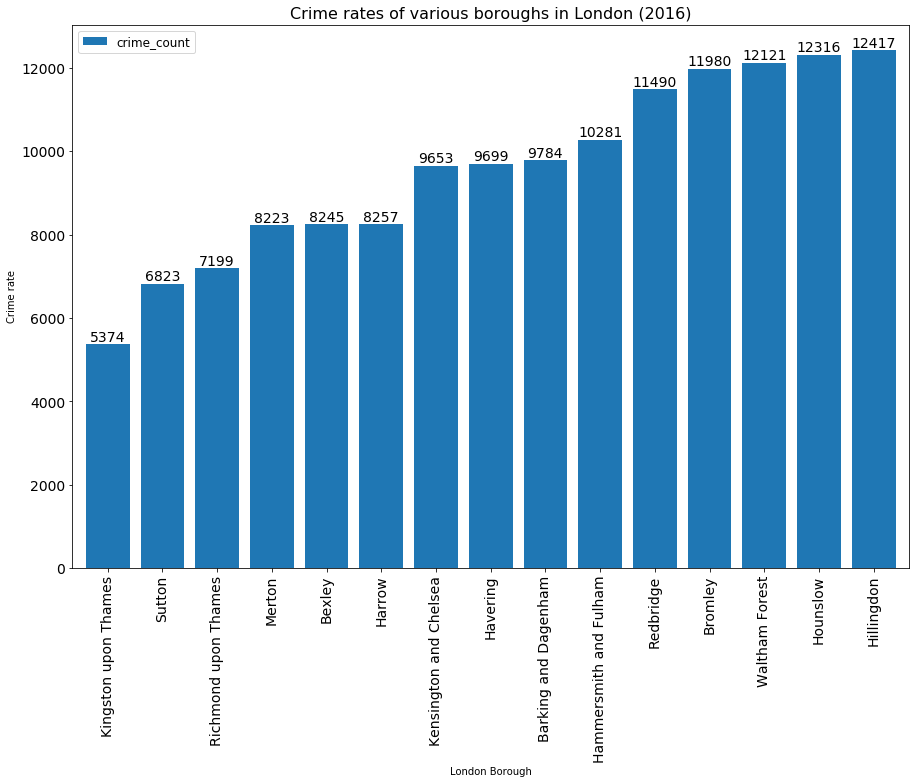

In [33]:
import matplotlib.pyplot as plt

ax = df_c.plot(kind='bar',
               figsize= (15, 10),
               width= 0.8,
               fontsize= 14)

ax.set_title("Crime rates of various boroughs in London (2016)", fontsize=16)
ax.set_ylabel('Crime rate')
ax.set_xlabel('London Borough')

ax.legend(prop=dict(size=12))
for rect in ax.patches:
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2
        va = 'top'
        label = y_value

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Vertically shift label by `space`
            xytext= (0,14),
            textcoords="offset points",
            ha='center',                # Horizontally center label
            va=va,                      
            fontsize=14)

Next, let's look at the price per square meter. 

In [34]:
df_hp.describe(include='all')

,price per m2
count,32.000000
mean,7473.187500
std,3423.874446
min,3994.000000
25%,5262.500000
50%,6510.000000
75%,8549.750000
max,19439.000000


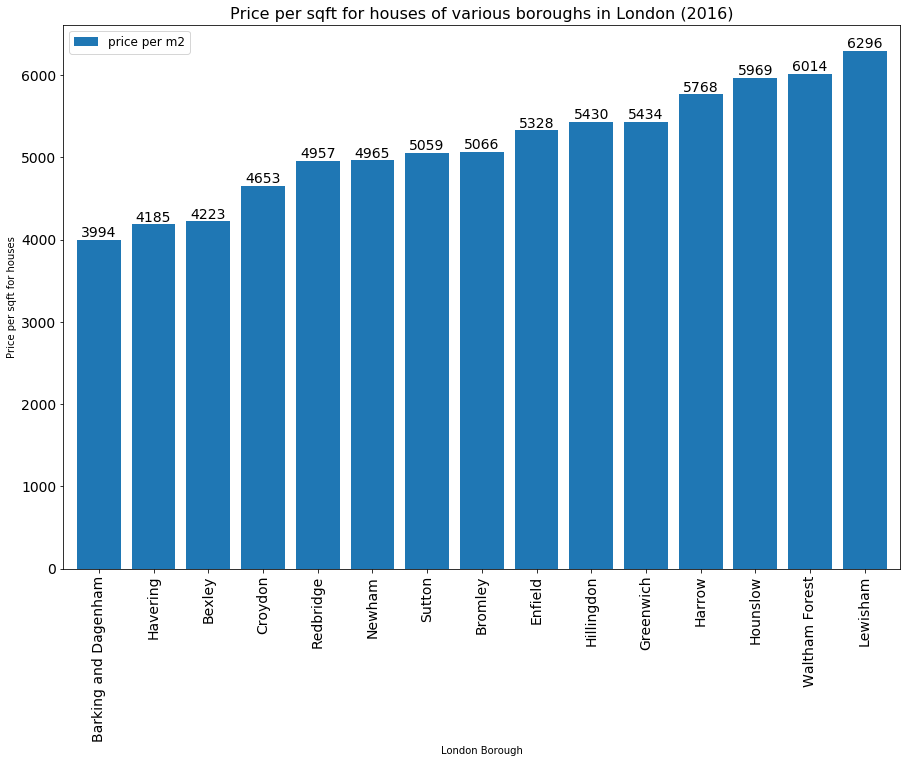

In [35]:

df_hp = df_hp[0:15]
ax = df_hp.plot(kind='bar',
               figsize= (15, 10),
               width= 0.8,
               fontsize= 14)

ax.set_title("Price per sqft for houses of various boroughs in London (2016)", fontsize=16)
ax.set_ylabel('Price per sqft for houses')
ax.set_xlabel('London Borough')

ax.legend(prop=dict(size=12))
for rect in ax.patches:
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2
        va = 'top'
        label = y_value

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Vertically shift label by `space`
            xytext= (0,14),
            textcoords="offset points",
            ha='center',                # Horizontally center label
            va=va,                      
            fontsize=14)

Based on the two graphs, we identify the boroughs with the lowest crime rates and more affordable homes. 

In [36]:
common_boroughs_c_hp = df_c.index.intersection(df_hp.index)
df_cb = pd.DataFrame(common_boroughs_c_hp)
df_cb

,London_Borough
0,Sutton
1,Bexley
2,Harrow
3,Havering
4,Barking and Dagenham
5,Redbridge
6,Bromley
7,Waltham Forest
8,Hounslow
9,Hillingdon


Now let's look at the happiness index. 

In [37]:
df_hi = happiness_index[0:15]
df_hi

,London_Borough
0,Richmond Upon Thames
1,Kingston upon Thames
2,Bromley
3,Sutton
4,Wandsworth
5,Camden
6,Barnet
7,Ealing
8,Greenwich
9,Havering


In [38]:
df_cb.merge(df_hi)

,London_Borough
0,Sutton
1,Havering
2,Bromley
3,Waltham Forest


Based on this exploratory analysis, SUTTON is the best borough for lower crime rates, more affordable housing, and happiness index. Next, we will analyze the districts within Sutton. Data will be taken from: https://en.wikipedia.org/wiki/London_Borough_of_Sutton#Districts

In [46]:
district = []
borough_name = []

neighborhood_details = {}
sutton_wiki = 'https://en.wikipedia.org/wiki/London_Borough_of_Sutton#Districts'
sutton_response = requests.get(sutton_wiki)
sutton_soup_obj = bs4.BeautifulSoup(sutton_response.text, 'html.parser')
district_table = sutton_soup_obj.find(class_='div-col') 

for dist_det in district_table.findAll('li'):
    d1 = dist_det.text.strip()
    dist_name = d1.split('(')[0]
    district.append(dist_name)
    borough_name.append('Sutton')

In [47]:
latitude = []
longitude = []

for dist in district:
    address = '{},London,United Kingdom'.format(dist)
    geolocator = Nominatim(user_agent="London_agent", timeout=10)
    location = geolocator.geocode(address)
    if location:
        latitude.append(location.latitude)
        longitude.append(location.longitude)
    else:
        latitude.append(np.nan)
        longitude.append(np.nan)

print(district,latitude, longitude)

['Bandon Hill', 'Beddington', 'Beddington Corner', 'Belmont', 'Benhilton', 'Carshalton', 'Carshalton Beeches', 'Carshalton on the Hill', 'Cheam', 'Hackbridge', 'Little Woodcote', 'North Cheam', 'Rosehill', 'St. Helier', 'South Beddington', 'Sutton ', 'Sutton Common', 'Sutton High Street ', 'The Wrythe', 'Wallington', 'Woodcote Green', 'Worcester Park'] [51.3647773, 51.3719875, 51.3869422, 51.3437847, 51.3716416, 51.3657883, 51.3571959, nan, 51.3576155, 51.3796135, 51.3460764, 51.3715776, 51.01250455, 51.3866947, 51.3719875, 51.3575114, 51.3753729, 51.3597647, 51.3670587, 51.357945, 51.3479908, 51.3783998] [-0.13483259828506877, -0.1323928, -0.1495322, -0.2011522, -0.1915714, -0.1610857, -0.1693507, nan, -0.2162414, -0.1567541, -0.1459324, -0.220225, -0.1406388422402289, -0.1800574, -0.1323928, -0.173640122600872, -0.1960317, -0.1909906, -0.1629561, -0.1495621, -0.1468304318627454, -0.2416023]


In [48]:
neighborhood_data = {'District': district,'Borough': borough_name, 'Latitude': latitude,'Longitude':longitude}
sutton_neighborhood = pd.DataFrame.from_dict(neighborhood_data)
sutton_neighborhood = sutton_neighborhood.dropna()
sutton_neighborhood

,District,Borough,Latitude,Longitude
0,Bandon Hill,Sutton,51.364777,-0.134833
1,Beddington,Sutton,51.371988,-0.132393
2,Beddington Corner,Sutton,51.386942,-0.149532
3,Belmont,Sutton,51.343785,-0.201152
4,Benhilton,Sutton,51.371642,-0.191571
5,Carshalton,Sutton,51.365788,-0.161086
6,Carshalton Beeches,Sutton,51.357196,-0.169351
8,Cheam,Sutton,51.357616,-0.216241
9,Hackbridge,Sutton,51.379613,-0.156754
10,Little Woodcote,Sutton,51.346076,-0.145932


Now, we will start modeling. The steps will include: identifying venues within a 500 meter radius of each neighborhood, one hot encoding on venue data, group venues by neighborhood, perform k-means clustering. 

In [49]:
CLIENT_ID = 'IVTMIY5L4MIIINQ12CIYDREXOQKU3BLIGNLVNUTREPI03HMV' # your Foursquare ID
CLIENT_SECRET = 'SSKWHGIVPFXAQ0BWEBQWQW1WM5M2WNRXHDZL4TEA0ACHYBEX' # your Foursquare Secret
VERSION = '20200210'

In [50]:
radius = 500
limit = 100

In [51]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'District Latitude', 
                  'District Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [52]:
sutton_venues = getNearbyVenues(names=sutton_neighborhood['District'],
                                 latitudes=sutton_neighborhood['Latitude'],
                                 longitudes=sutton_neighborhood['Longitude']
                                )

In [53]:
print(sutton_venues.shape)
sutton_venues.head(n=10)

(189, 7)


,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bandon Hill,51.364777,-0.134833,The Plough,51.367633,-0.132089,Pub
1,Bandon Hill,51.364777,-0.134833,Asif Balti House,51.367795,-0.132356,Indian Restaurant
2,Bandon Hill,51.364777,-0.134833,Londis,51.367782,-0.131824,Convenience Store
3,Bandon Hill,51.364777,-0.134833,Mellows Park,51.360692,-0.134101,Park
4,Beddington,51.371988,-0.132393,Carew Manor,51.370983,-0.136604,Park
5,Beddington,51.371988,-0.132393,Wickes,51.375519,-0.130732,Hardware Store
6,Beddington,51.371988,-0.132393,Asif Balti House,51.367795,-0.132356,Indian Restaurant
7,Beddington,51.371988,-0.132393,The Plough,51.367633,-0.132089,Pub
8,Beddington Corner,51.386942,-0.149532,Traq,51.389091,-0.144979,Racetrack
9,Beddington Corner,51.386942,-0.149532,TNT Croydon Depot,51.389079,-0.144074,Business Service


In [54]:
print('The number of popular venues in each district of Sutton Borough are as follows:')
sutton_venues.groupby('District').count()

The number of popular venues in each district of Sutton Borough are as follows:


,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
District,,,,,,
Bandon Hill,4,4,4,4,4,4
Beddington,4,4,4,4,4,4
Beddington Corner,2,2,2,2,2,2
Belmont,5,5,5,5,5,5
Benhilton,8,8,8,8,8,8
Carshalton,14,14,14,14,14,14
Carshalton Beeches,5,5,5,5,5,5
Cheam,23,23,23,23,23,23
Hackbridge,4,4,4,4,4,4


In [55]:
print('There are %d unique categories of venues in Sutton Borough' % len(sutton_venues['Venue Category'].unique()))
sutton_venues['Venue Category'].unique()

There are 58 unique categories of venues in Sutton Borough


array(['Pub', 'Indian Restaurant', 'Convenience Store', 'Park',
       'Hardware Store', 'Racetrack', 'Business Service', 'Train Station',
       'Asian Restaurant', 'Bus Stop', 'Playground',
       'Gym / Fitness Center', 'Supermarket', 'Coffee Shop',
       'Pizza Place', 'Clothing Store', 'Grocery Store', 'Hotel', 'Café',
       'Veterinarian', 'Platform', 'Italian Restaurant', 'Bakery',
       'Fabric Shop', 'Thai Restaurant', 'Creperie',
       'American Restaurant', 'Gastropub', 'Stationery Store',
       'Salon / Barbershop', 'Restaurant', 'Soccer Field', 'River',
       'Garden Center', 'Sports Club', 'Social Club',
       'Seafood Restaurant', 'Turkish Restaurant', 'Fast Food Restaurant',
       'Pharmacy', 'Breakfast Spot', 'Tennis Court', 'Athletics & Sports',
       'Portuguese Restaurant', 'Gym', 'Bookstore', 'French Restaurant',
       'Bar', 'Sandwich Place', 'Irish Pub', 'Tea Room',
       'Spanish Restaurant', 'Fish & Chips Shop', 'BBQ Joint',
       'Cosmetics Shop', 

Next, we will perform one hot encoding on the venue data. 

In [56]:
sutton_onehot = pd.get_dummies(sutton_venues[['Venue Category']], prefix="", prefix_sep="")
# add neighborhood column back to dataframe
sutton_onehot['District'] = sutton_venues['District'] 
column_names = [sutton_onehot.columns[-1]] + list(sutton_onehot.columns[0:-1])
sutton_onehot = sutton_onehot[column_names]
sutton_onehot.head()

,District,American Restaurant,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bar,Bookstore,Breakfast Spot,Bus Stop,Business Service,Café,Clothing Store,Coffee Shop,Convenience Store,Cosmetics Shop,Creperie,Fabric Shop,Fast Food Restaurant,Fish & Chips Shop,French Restaurant,Garden Center,Gastropub,Grocery Store,Gym,Gym / Fitness Center,Hardware Store,Hotel,Indian Restaurant,Irish Pub,Italian Restaurant,Lebanese Restaurant,Park,Pet Service,Pet Store,Pharmacy,Pizza Place,Platform,Playground,Portuguese Restaurant,Pub,Racetrack,Restaurant,River,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Soccer Field,Social Club,Spanish Restaurant,Sports Club,Stationery Store,Supermarket,Tea Room,Tennis Court,Thai Restaurant,Train Station,Turkish Restaurant,Veterinarian
0,Bandon Hill,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Bandon Hill,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Bandon Hill,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Bandon Hill,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Beddington,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [57]:
sutton_grouped = sutton_onehot.groupby("District").mean().reset_index()
sutton_grouped.head()

,District,American Restaurant,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bar,Bookstore,Breakfast Spot,Bus Stop,Business Service,Café,Clothing Store,Coffee Shop,Convenience Store,Cosmetics Shop,Creperie,Fabric Shop,Fast Food Restaurant,Fish & Chips Shop,French Restaurant,Garden Center,Gastropub,Grocery Store,Gym,Gym / Fitness Center,Hardware Store,Hotel,Indian Restaurant,Irish Pub,Italian Restaurant,Lebanese Restaurant,Park,Pet Service,Pet Store,Pharmacy,Pizza Place,Platform,Playground,Portuguese Restaurant,Pub,Racetrack,Restaurant,River,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Soccer Field,Social Club,Spanish Restaurant,Sports Club,Stationery Store,Supermarket,Tea Room,Tennis Court,Thai Restaurant,Train Station,Turkish Restaurant,Veterinarian
0,Bandon Hill,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.00,0.0,0.250,0.0,0.0,0.0,0.250,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0
1,Beddington,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.25,0.0,0.250,0.0,0.0,0.0,0.250,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0
2,Beddington Corner,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.000,0.000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.00,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.00,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0
3,Belmont,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.000,0.000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.00,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.2,0.0,0.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.2,0.0,0.0
4,Benhilton,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125,0.125,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125,0.0,0.125,0.00,0.0,0.125,0.0,0.0,0.0,0.125,0.0,0.0,0.0,0.125,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125,0.0,0.0,0.0,0.0,0.0,0.0


Top three venues in each neighborhood. 

In [58]:
num_top_venues = 3

for hood in sutton_grouped['District']:
    print("***********"+hood+"***********")
    temp = sutton_grouped[sutton_grouped['District'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

***********Bandon Hill***********
               venue  freq
0               Park  0.25
1  Indian Restaurant  0.25
2                Pub  0.25


***********Beddington***********
               venue  freq
0               Park  0.25
1  Indian Restaurant  0.25
2     Hardware Store  0.25


***********Beddington Corner***********
                 venue  freq
0     Business Service   0.5
1            Racetrack   0.5
2  American Restaurant   0.0


***********Belmont***********
              venue  freq
0  Asian Restaurant   0.2
1     Train Station   0.2
2          Bus Stop   0.2


***********Benhilton***********
            venue  freq
0            Park  0.12
1  Clothing Store  0.12
2     Pizza Place  0.12


***********Carshalton***********
           venue  freq
0           Park  0.14
1            Pub  0.14
2  Grocery Store  0.14


***********Carshalton Beeches***********
                venue  freq
0  Italian Restaurant   0.2
1         Fabric Shop   0.2
2       Train Station   0.2


*******

In [59]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [60]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['District']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['District'] = sutton_grouped['District']

for ind in np.arange(sutton_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(sutton_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bandon Hill,Park,Pub,Convenience Store,Indian Restaurant,Veterinarian,Creperie,Hardware Store,Gym / Fitness Center,Gym,Grocery Store
1,Beddington,Indian Restaurant,Hardware Store,Park,Pub,Veterinarian,Gym / Fitness Center,Gym,Grocery Store,Gastropub,Garden Center
2,Beddington Corner,Business Service,Racetrack,Veterinarian,Cosmetics Shop,Hardware Store,Gym / Fitness Center,Gym,Grocery Store,Gastropub,Garden Center
3,Belmont,Train Station,Asian Restaurant,Bus Stop,Playground,Pub,Veterinarian,Creperie,Gym / Fitness Center,Gym,Grocery Store
4,Benhilton,Indian Restaurant,Gym / Fitness Center,Coffee Shop,Park,Supermarket,Grocery Store,Clothing Store,Pizza Place,French Restaurant,Fast Food Restaurant


Now, let's use kmeans clustering. First we must determine the optimal number of clusters using the elbow method. 

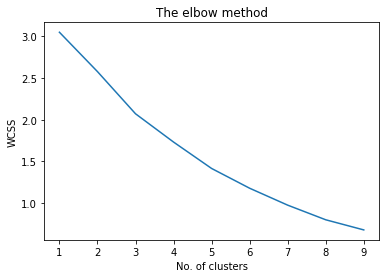

In [61]:
from sklearn.cluster import KMeans
wcss = []

sutton_grouped_clustering = sutton_grouped.drop('District', 1)

for i in range(1,10):
    kmeans = KMeans(n_clusters = i, init= 'k-means++', max_iter=2000, n_init=10, random_state =0)
    kmeans.fit(sutton_grouped_clustering)
    wcss.append(kmeans.inertia_) #calculate wcss and append it to a list
plt.plot(range(1,10), wcss)
plt.title('The elbow method')
plt.xlabel('No. of clusters')
plt.ylabel('WCSS')
plt.show()

In [94]:
# run k-means clustering - 3 clusters based on above graph 
kmeans = KMeans(n_clusters=3, random_state=0).fit(sutton_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 2, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [95]:
neighborhoods_venues_sorted.iloc[0:0]
neighborhoods_venues_sorted.insert(0, 'Cluster_FINAL', kmeans.labels_)
neighborhoods_venues_sorted
sutton_merged = sutton_neighborhood

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
sutton_merged= sutton_merged.join(neighborhoods_venues_sorted.set_index('District'), on='District')

sutton_merged.head()

,District,Borough,Latitude,Longitude,Cluster_FINAL,Cluster_Label,Cluster Label,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bandon Hill,Sutton,51.364777,-0.134833,0,1,0,1,Park,Pub,Convenience Store,Indian Restaurant,Veterinarian,Creperie,Hardware Store,Gym / Fitness Center,Gym,Grocery Store
1,Beddington,Sutton,51.371988,-0.132393,0,1,0,1,Indian Restaurant,Hardware Store,Park,Pub,Veterinarian,Gym / Fitness Center,Gym,Grocery Store,Gastropub,Garden Center
2,Beddington Corner,Sutton,51.386942,-0.149532,2,4,2,4,Business Service,Racetrack,Veterinarian,Cosmetics Shop,Hardware Store,Gym / Fitness Center,Gym,Grocery Store,Gastropub,Garden Center
3,Belmont,Sutton,51.343785,-0.201152,1,2,1,2,Train Station,Asian Restaurant,Bus Stop,Playground,Pub,Veterinarian,Creperie,Gym / Fitness Center,Gym,Grocery Store
4,Benhilton,Sutton,51.371642,-0.191571,1,2,1,2,Indian Restaurant,Gym / Fitness Center,Coffee Shop,Park,Supermarket,Grocery Store,Clothing Store,Pizza Place,French Restaurant,Fast Food Restaurant


In [96]:
address = 'Sutton,London,United Kingdom '

geolocator = Nominatim(user_agent="sutton_explorer", timeout=3)
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Sutton are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Sutton are 51.3575114, -0.173640122600872.


In [97]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(6)
ys = [i + x + (i*x)**2 for i in range(6)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(sutton_merged['Latitude'], sutton_merged['Longitude'], sutton_merged['District'], sutton_merged['Cluster_FINAL']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
        
map_clusters

In [98]:
sutton_merged[sutton_merged['Cluster_FINAL'] == 0]

,District,Borough,Latitude,Longitude,Cluster_FINAL,Cluster_Label,Cluster Label,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bandon Hill,Sutton,51.364777,-0.134833,0,1,0,1,Park,Pub,Convenience Store,Indian Restaurant,Veterinarian,Creperie,Hardware Store,Gym / Fitness Center,Gym,Grocery Store
1,Beddington,Sutton,51.371988,-0.132393,0,1,0,1,Indian Restaurant,Hardware Store,Park,Pub,Veterinarian,Gym / Fitness Center,Gym,Grocery Store,Gastropub,Garden Center
14,South Beddington,Sutton,51.371988,-0.132393,0,1,0,1,Indian Restaurant,Hardware Store,Park,Pub,Veterinarian,Gym / Fitness Center,Gym,Grocery Store,Gastropub,Garden Center


The first cluster consists of the Bandon Hill, Beddington, and South Beddington districts. This cluster mainly contains parks, Indian restaurants, hardware stores, and pubs. Based on this data, this district seems to be a more residential area. 

In [99]:
sutton_merged[sutton_merged['Cluster_FINAL'] == 1]

,District,Borough,Latitude,Longitude,Cluster_FINAL,Cluster_Label,Cluster Label,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Belmont,Sutton,51.343785,-0.201152,1,2,1,2,Train Station,Asian Restaurant,Bus Stop,Playground,Pub,Veterinarian,Creperie,Gym / Fitness Center,Gym,Grocery Store
4,Benhilton,Sutton,51.371642,-0.191571,1,2,1,2,Indian Restaurant,Gym / Fitness Center,Coffee Shop,Park,Supermarket,Grocery Store,Clothing Store,Pizza Place,French Restaurant,Fast Food Restaurant
5,Carshalton,Sutton,51.365788,-0.161086,1,2,1,2,Grocery Store,Park,Pub,Veterinarian,Café,Train Station,Gym / Fitness Center,Hotel,Coffee Shop,Bus Stop
6,Carshalton Beeches,Sutton,51.357196,-0.169351,1,0,1,0,Train Station,Italian Restaurant,Bakery,Grocery Store,Fabric Shop,Veterinarian,Cosmetics Shop,Hardware Store,Gym / Fitness Center,Gym
8,Cheam,Sutton,51.357616,-0.216241,1,2,1,2,Pub,Coffee Shop,Italian Restaurant,Grocery Store,American Restaurant,Indian Restaurant,Pizza Place,Thai Restaurant,Park,Gastropub
9,Hackbridge,Sutton,51.379613,-0.156754,1,2,1,2,River,Train Station,Supermarket,Park,Convenience Store,Gym / Fitness Center,Gym,Grocery Store,Gastropub,Garden Center
10,Little Woodcote,Sutton,51.346076,-0.145932,1,5,3,5,Park,Sports Club,Garden Center,Coffee Shop,Veterinarian,Cosmetics Shop,Hardware Store,Gym / Fitness Center,Gym,Grocery Store
11,North Cheam,Sutton,51.371578,-0.220225,1,2,1,2,Coffee Shop,Gym / Fitness Center,Social Club,Fast Food Restaurant,Seafood Restaurant,Soccer Field,Pub,Supermarket,Grocery Store,Turkish Restaurant
12,Rosehill,Sutton,51.012505,-0.140639,1,2,1,2,Restaurant,Grocery Store,Business Service,Pub,Veterinarian,Hardware Store,Gym / Fitness Center,Gym,Gastropub,Garden Center
13,St. Helier,Sutton,51.386695,-0.180057,1,3,1,3,Pharmacy,Breakfast Spot,Coffee Shop,Veterinarian,Creperie,Hardware Store,Gym / Fitness Center,Gym,Grocery Store,Gastropub


THe second cluster is by far the largest cluster in this analysis. The top common venues in this cluster include: train stations, pubs, grocery stores, coffee shops, gym/fitness center, cafe. Based on this data, this cluster seems to be a busy, happening, and perhaps central area of Sutton. 

In [100]:
sutton_merged[sutton_merged['Cluster_FINAL'] == 2]

,District,Borough,Latitude,Longitude,Cluster_FINAL,Cluster_Label,Cluster Label,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Beddington Corner,Sutton,51.386942,-0.149532,2,4,2,4,Business Service,Racetrack,Veterinarian,Cosmetics Shop,Hardware Store,Gym / Fitness Center,Gym,Grocery Store,Gastropub,Garden Center


The last cluster in this analysis solely consists of the Beddington Corner district, which consists of business services, racetrack, and vet. Based on this data, this area seems to be quieter and perhaps more of a business area, rather than a residential area. 

### Results and Discussion 

As a young professional looking to move to London, I have various requirements regarding possible neighborhoods to move into: afforadability, crime rates, and general vibe (happiness). Based on this analysis, I have come to the conclusion that the Sutton borough would be the best location for my preferences. Within Sutton, the best neighborhoods would be any in the second cluster because those areas had numerous and diverse venues that fits my lifestyle - active, accessible, and social. 

### Conclusion 

The Battle of the Neighborhoods assignment was extremely useful in helping me understand the application of k-means clustering in determining the best neighborhoods based on certain characteristics. 